mmMNIST data set implementation from
CentralNet: a Multilayer Approach for Multimodal Fusion (https://arxiv.org/abs/1808.07275)
Deep learning for multimodal and temporal contents analysis (pp. 95) (https://tel.archives-ouvertes.fr/tel-02437035/)

In [2]:
from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Load the data

mnist = fetch_openml('mnist_784')
X = mnist['data']

# or take a particular label from the dataset
#label = '1'
#X = np.take(mnist['data'], np.argwhere(mnist['target'] == label)[:,0], axis = 0)

# Take the data with the following index for plotting
idx = 1


The PCA allows going from the original data dimensionality to some reduced dimensionality that explaine a given percentage of the original information (i.e. explained variance).
One advantage about PCA is that one can go from the reduced representation back to an approximation of the original high dimensional data (784 components).
In the following example 95% of information form the original dimensionality of 784 is kept in 154 dimension.

In [4]:
def pca_inverse_transform(X, pca_obj, idx_components=None):
    '''like inverse_transform, but with index for the components used for inverse transformation

    :param X: data for transformation
    :param pca_obj: the PCA object
    :param idx_components: list of components for inverse transformation
    :return: the transformed data
    '''
    if idx_components is None:
        idx_components = list(range(pca.n_features_))
    X_ = np.take(X, idx_components, axis=1)
    explained_variance_ = np.sqrt(np.take(pca_obj.explained_variance_, idx_components, axis=0)[:, np.newaxis])
    components_ = np.take(pca_obj.components_, idx_components, axis=0)
    mean_ = pca_obj.mean_
    if pca_obj.whiten:
        return np.dot(X_, explained_variance_ * components_) + mean_
    else:
        return np.dot(X_, components_) + mean_


# calculate dimension reduction for 95% of explained variance and perform the inverse
exp_var = .95
pca_95 = PCA(exp_var)
pca_95.fit(X)
X_red_95 = pca_95.transform(X[[idx]])
print("Remaining components for %f explained variance: %d" %(exp_var, pca_95.n_components_))
X_approx_95 = pca_95.inverse_transform(X_red_95)

# calculate dimension reduction for 100% of explained variance, which just performs a
# diagonalisation of the data, and perform the inverse for 154 components
pca = PCA()
pca.fit(X)
X_red = pca.transform(X[[idx]])
X_approx = pca_inverse_transform(X_red, pca, idx_components=list(range(pca_95.n_components_)))

Remaining components for 0.950000 explained variance: 154


Show two approaches for approaching the inverse calulcation using scipy:
First, we give the value for explained variance explicitely (ie. 95%).
Second, we diagonalize the full dimension and only choose the number of components which are equivalent to 95% of the explained variance. 

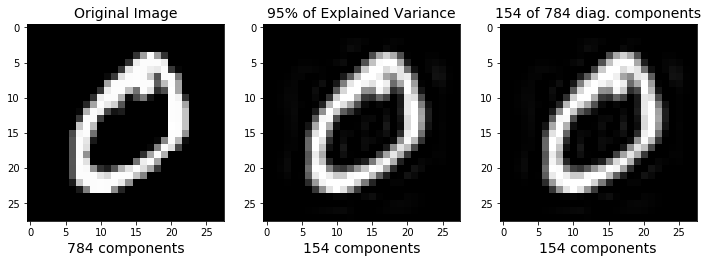

In [5]:
_, ax = plt.subplots(1,3, figsize=(12,4))

ax[0].imshow(X[idx].reshape(28,28), cmap = plt.cm.gray, clim=(0, 255))
ax[0].set_xlabel('784 components', fontsize = 14)
ax[0].set_title('Original Image', fontsize = 14)

ax[1].imshow(X_approx_95.reshape(28, 28), cmap = plt.cm.gray, clim=(0, 255))
ax[1].set_xlabel('154 components', fontsize = 14)
ax[1].set_title('95% of Explained Variance', fontsize = 14)

ax[2].imshow(X_approx.reshape(28, 28), cmap = plt.cm.gray, clim=(0, 255))
ax[2].set_xlabel('154 components', fontsize = 14)
ax[2].set_title('154 of 784 diag. components', fontsize = 14)

plt.show()

Show various amounts of explained variance from 100% (original image) to 0% (mean image). 

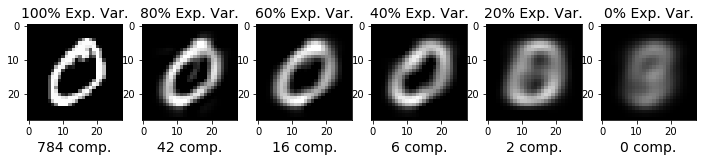

In [6]:
_, ax = plt.subplots(1,6, figsize=(12,2))
def plot_image(idx_X, idx_img, exp_var):
    ''' Calculate the number of components based on given explained variance '''
    X_red = pca.transform(X[[idx_X]])
    # Calc the normalized cumsum to find the number of components used for reconstruction 
    cumrel_exp_var = pca.explained_variance_.cumsum() / pca.explained_variance_.sum()
    if exp_var >= 1.:
        idx_component = pca.n_features_
    else:
        idx_component = np.argmax(cumrel_exp_var >= exp_var)
    X_approx = pca_inverse_transform(X_red, pca, idx_components=list(range(idx_component)))
    # plot
    ax[idx_img].imshow(X_approx.reshape(28,28), cmap = plt.cm.gray, clim=(0, 255))
    ax[idx_img].set_title('%d%% Exp. Var.' %(int(exp_var*100.)), fontsize = 14)
    ax[idx_img].set_xlabel('%d comp.' %(idx_component), fontsize = 14)

plot_image(idx, 0, 1.)
plot_image(idx, 1, .8)
plot_image(idx, 2, .6)
plot_image(idx, 3, .4)
plot_image(idx, 4, .2)
plot_image(idx, 5, .0)

Show a plot of the cumulative explained variance, which connects the explained varaince with the number of components.

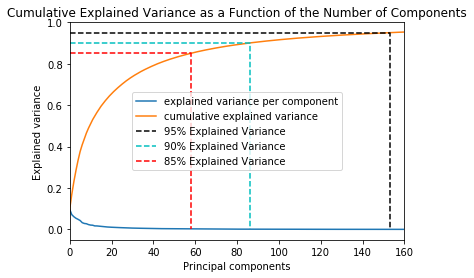

In [7]:
_, ax = plt.subplots(1,1)

tot_exp_var = pca.explained_variance_.sum()
rel_exp_var = pca.explained_variance_ / tot_exp_var
cumrel_exp_var = pca.explained_variance_.cumsum() / tot_exp_var
ax.plot(rel_exp_var, label='explained variance per component')
ax.plot(cumrel_exp_var, label = 'cumulative explained variance')
ax.set_title('Cumulative Explained Variance as a Function of the Number of Components')
ax.set_ylabel('Explained variance')
ax.set_xlabel('Principal components')
comp_85 = np.argmax(cumrel_exp_var >= .85)
comp_90 = np.argmax(cumrel_exp_var >= .90)
comp_95 = np.argmax(cumrel_exp_var >= .95)
ax.plot([0, comp_95, comp_95], [.95, .95, 0], color='k', linestyle='--', label = '95% Explained Variance')
ax.plot([0, comp_90, comp_90], [.90, .90, 0], color='c', linestyle='--', label = '90% Explained Variance')
ax.plot([0, comp_85, comp_85], [.85, .85, 0], color='r', linestyle='--', label = '85% Explained Variance')
ax.set_xlim([0, 160])
ax.set_ylim([-0.05, 1.])
plt.legend(loc='best')

plt.show()


Define multi-modal MNIST

In [8]:

def get_idx_components(energy=0.5, overlap=0., early_stopping=False):
    '''

    :param energy: relative energy per component (0 .. 5.)
    :param overlap: percentage of energy overlap between the modalities
    :param early_stopping: stop adding components if reaching 'energy', otherwise add later components which might fit
    :return: components for modality a and b
    '''
    if energy > .5 or energy <= .0:
        raise ValueError('Choose "0 < energy <= .5"')
    if overlap > 1. or overlap < .0:
        raise ValueError('Choose "0 <= overlapp <= 1."')
    idx_components_a, idx_components_b, idx_components_overlap = [], [], []
    energy_a, energy_b, energy_overlap = 0., 0., 0.
    stop_adding_a, stop_adding_b, stop_adding_overlap = False, False, False
    # Assign the components to each modality
    rel_explained_variance = pca.explained_variance_ / pca.explained_variance_.sum()

    def update(energy_cum, energy_curr, energy_max, stop_adding, idx_components):
        ''' Update the components and energy

        :param energy_cum: cumulative energy of the modality
        :param energy_curr: current energy
        :param energy_max: maximum energy with energy_cum < energy_max
        :param stop_adding: indicator for stopping the adding
        :param idx_components: mutable components list
        :return: updated cumulative energy and indicator
        '''
        if energy_cum + energy_curr <= energy_max and not stop_adding:
            idx_components.append(i)
            energy_cum += v
        else:
            if early_stopping:
                stop_adding = True
        return energy_cum, stop_adding

    # Handle overlap
    for i, v in enumerate(rel_explained_variance):
        energy_overlap, stop_adding_overlap = update(energy_overlap, v, energy * overlap, stop_adding_overlap, idx_components_overlap)
    # copy back
    idx_components_a = idx_components_overlap.copy()
    idx_components_b = idx_components_overlap.copy()
    energy_a, energy_b = energy_overlap, energy_overlap

    # Handle the non-overlapping components
    for i, v in enumerate(rel_explained_variance):
        # skip, if the component is already given in the overlap
        if i in idx_components_overlap:
            continue
        # add the remaining components
        if not np.mod(i, 2):
            energy_a, stop_adding_a = update(energy_a, v, energy, stop_adding_a, idx_components_a)
        else:
            energy_b, stop_adding_b = update(energy_b, v, energy, stop_adding_b, idx_components_b)
    return idx_components_a, idx_components_b


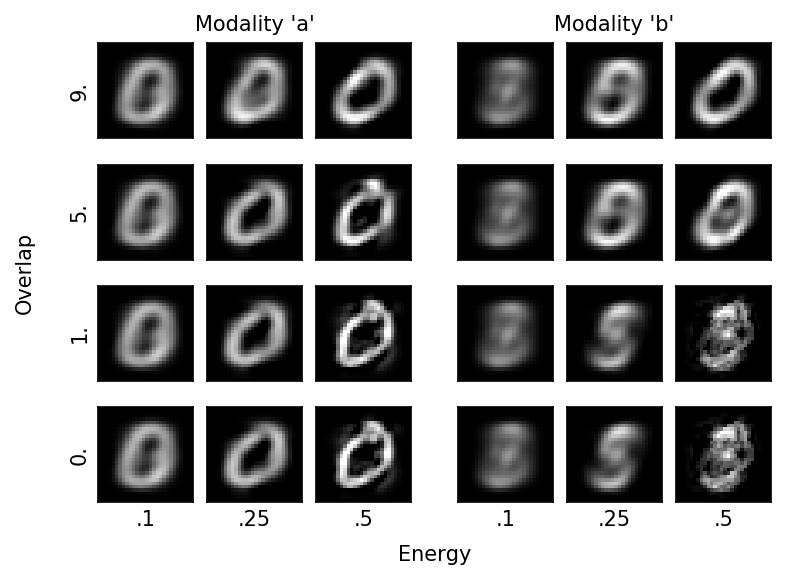

In [9]:

paper_width_cm = 15
paper_width_inch = paper_width_cm / 2.54
dpi = 150
fig_w = paper_width_inch         # 7 images
fig_h = paper_width_inch * 4 / 7 * 1.2 # 4 images


widths = [1, 1, 1, 0.3, 1, 1, 1]
sep = .15
heights = [1, sep, 1, sep, 1, sep, 1]
gs_kw = dict(width_ratios=widths, height_ratios=heights, wspace=0., hspace=.1)

f, axs = plt.subplots(7,7,figsize=(fig_w,fig_h), dpi=dpi, sharey=True, sharex=True,  gridspec_kw = gs_kw)

# Remove the lines of the seperators
for xy in [(y, x) for y in [1, 3, 5] for x in range(7)] + [(y, 3) for y in range(7)]:
    ax = axs[xy[0]][xy[1]]
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.axis('off')

def plot_modalities(idx_X, id_img, idx_component):
    ''' Plot the inverse for the given component list '''
    X_red = pca.transform(X[[idx_X]])
    X_approx = pca_inverse_transform(X_red, pca, idx_components=idx_component)
    # plot
    axs[id_img[0], id_img[1]].imshow(X_approx.reshape(28, 28), cmap=plt.cm.gray, clim=(0, 255))
    axs[id_img[0], id_img[1]].tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)

def plot_labels(id_img, title = "", xlabel = "", ylabel = ""):
    ''' Add corresponding information '''
    axs[id_img[0], id_img[1]].set_title(title, fontsize=10)
    axs[id_img[0], id_img[1]].set_xlabel(xlabel, fontsize=10)
    axs[id_img[0], id_img[1]].set_ylabel(ylabel, fontsize=10)

# Write the xlabel for the parameters
plot_labels([-1, 0], title = "", xlabel = ".1", ylabel = "0.")
plot_labels([-3, 0], title = "", xlabel = "", ylabel = "1.")
plot_labels([-5, 0], title = "", xlabel = "", ylabel = "5.")
plot_labels([-7, 0], title = "", xlabel = "", ylabel = "9.")
plot_labels([-1, 1], title = "", xlabel = ".25", ylabel = "")
plot_labels([-1, 2], title = "", xlabel = ".5", ylabel = "")
plot_labels([-1, 4], title = "", xlabel = ".1", ylabel = "")
plot_labels([-1, 5], title = "", xlabel = ".25", ylabel = "")
plot_labels([-1, 6], title = "", xlabel = ".5", ylabel = "")
plot_labels([0, 1], title = "Modality 'a'", xlabel = "", ylabel = "")
plot_labels([0, 5], title = "Modality 'b'", xlabel = "", ylabel = "")

energy = [.1, .25, .5]
overlap = [0., .1, .5, .9]

for ie, e in enumerate(energy):
    for io, o in enumerate(overlap):
        idx_components_a, idx_components_b = get_idx_components(energy=e, overlap=o, early_stopping=True)
        plot_modalities(idx, [-io*2-1, ie], idx_components_a)
        plot_modalities(idx, [-io*2-1, 4+ie], idx_components_b)

# add a big axis, hide frame
f.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.xlabel("Energy")
plt.ylabel("Overlap")

#plt.savefig("/tmp/dsprites.pdf", dpi='figure', transparent=True, papertype='a4', bbox_inches='tight')
plt.show()
